# 📝 NOTE

Unless you have chosen to train with the `fineweb-100m` dataset, training on a CPU for a GPT-2 355M model over 1 billion tokens is not a good use of time and resources. 

For this notebook, we'll leverage **GPU training**. It's really the only way to do training within a reasonable amount of time.

If you don't have access to a GPU, there are a few good options out there such as:

* Lambda Cloud - https://lambda.ai/service/gpu-cloud
* Fly IO - https://fly.io/
* Google Cloud - https://cloud.google.com/gpu
* Akamai Cloud - https://www.linode.com/products/gpu/

For this notebook, I used my personal NVIDIA RTX 6000 ADA GPU to train. 

The amount of VRAM necessary is dependent upon the batch size. If you have an older card, most likely you'll be using anywhere between 1, 2, or 4 for the batch size. Newer cards can leverage `bfloat16` data type and that significantly reduces the memory necessary to train. You can look to have anywhere from a batch size of 8 to 32.

My card supports `bfloat16`, and so do most cloud GPUs now. So the code will be written with that assumption. Adjust the `batch_size` variable as needed when appropriate.

# Cost of Cloud Training

Training on the cloud can be costly, but you can reduce the costs by:

- Picking instances with only a single GPU (this notebook only requires one)
- Using an older GPU (Turing, Ampere, etc.)
- Using a smaller cloud provider
- Doing as much pre-processing locally (dataset generation) as much as possible

# Pretraining 2 - GPT-2 355M 

**Note** - I've included the training script `model_train.py` at the same level of this notebook. It is the script I had actually used to produce the model. 

So now we're going to train the 355M parameter model. Our goal here is to produce a high quality, foundational model in which we will be able to use for fine-tuning on various other applications and then do inference on CPU, GPU and our Tenstorrent Wormhole. :) 

# Defining Variables

Define the `dataset_name` and `device` we'll be using. `cuda:1` is used because I have 2 CUDA cards on my server, where `cuda:1` is the one I want to use for training.

In [28]:
dataset_name = 'fineweb-100m'
device = "cuda:1"

# Ensuring a Clean Environment

Let's make sure that our GPU has enough memory to do our training. Let's force garbage collection and empty cuda cache to free up VRAM.

In [18]:
import torch
import gc

gc.collect()

if device.startswith("cuda"):
    torch.cuda.empty_cache()

## Loading the Input and Validation Tokens

We created the dataloaders in the previous notebook. Let's load them back up.

In [19]:
from scripts.preload_dataloaders import load_pickled_dataloader

train_loader = load_pickled_dataloader(f"data/{dataset_name}/train_loader.dl")
print("Loaded train_loader.")

val_loader = load_pickled_dataloader(f"data/{dataset_name}/val_loader.dl")
print("Loaded val_loader")

len(train_loader), len(val_loader)

Loaded train_loader.
Loaded val_loader


(26022, 4592)

Validate for the maximum token ID. This makes sure that we don't have any token IDs out of range. Being out of range means that our dataloader could be corrupted. I ended up having to do this because I had bad data in the previous notebook, causing re-do of the loader construction.

In [20]:
# To check token ID range in your dataset
max_token = float('-inf')
for i, (input_batch, _) in enumerate(train_loader):
    max_token = max(max_token, input_batch.max().item())

print(f"Maximum token ID: {max_token}")

Maximum token ID: 50256


# Load Up Test Model

Let's load up a test model using the GPT2 355M configuration and see what we have! It's also a good way to test moving the model to device to see if we're set up for success.

In [21]:
from scripts.gpt2_model import GPTModel
from scripts.gpt2_common import GPT_CONFIG_355M

model = GPTModel(GPT_CONFIG_355M)
model = model.to(device)

## Existing Training and Validation Loss

If you're somehow reloading a model, it's useful to check out the current training and validaton loss. Warning, this will perform a forward pass on all your data, so it is still an expensive effort 

In [22]:
import torch
import gc
from scripts.train import calc_loss_loader

torch.manual_seed(123)

# use the num_batches parameter to limit the number of batches processed
# 20/2 should be enough to tell us something.
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device=device, num_batches=20)
  val_loss = calc_loss_loader(val_loader, model, device=device, num_batches=2)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

gc.collect()
if device.startswith("cuda"):
  torch.cuda.empty_cache()

Training loss: 10.997357416152955
Validation loss: 11.004929065704346


## Training

Now it is time to train our 355M model. Running this script n the notebook is actually not a good thing to do. It will take took long. I have included 2 scripts you can run within a `tmux` session so that you can disconnect from your session while still having your training continue. 

* `model_train.py`
* `model_inference.py`.

In `train_model_simple`, I have modified the code to take in a `device` argument now to accommodate a GPU. This cause a ripple effect of adding the arguments elswhere. 

Additionally, I included a new `max_iters` argument to only train the model up to a specific number of steps as an entire epoch would take too long if just needing to test. We will be using the `max_iters` argument to make sure that this cell finishes within a reasonable amount of time.

In [23]:
import torch
import tiktoken
from scripts.perf_timer import PerfTimer
from scripts.train import train_model_simple
from scripts.gpt2_model import GPTModel
from scripts.gpt2_common import GPT_CONFIG_355M

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

# Configure the device
if device.startswith("cuda"):
  capability = torch.cuda.get_device_capability()
  if capability[0] >= 7:
    print("Modern CUDA device found. Using tensor cores.")
    torch.set_float32_matmul_precision("high")
  else:
    print("Tensor cores not supported on this CPU. Will still proceed.")

model = GPTModel(GPT_CONFIG_355M)

# Move model to device BEFORE compiling
if device.startswith("cuda"):
  torch.cuda.empty_cache()
  model = model.to(device).to(torch.bfloat16)
else:
  model = model.to(device)
model = torch.compile(model)
model.train()

optimizer = torch.optim.AdamW(
  model.parameters(),
  lr=2e-4,
  weight_decay=0.1,
  fused=True
)

# We have lots of data, so we can just train for a single epoch.
num_epochs = 1

timer = PerfTimer()

timer.start()
train_losses, val_losses = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    eval_freq=100,
    eval_iter=10, # eval less frequently
    start_context="Every effort moves you",
    tokenizer=tokenizer,
    device=device,
    max_iter=100
)
timer.stop()

print(f"Took this long to train: {timer.elapsed_ms()} ms")
print("Train losses\n")
print(train_losses)
print("Val losses\n")
print(val_losses)

import gc
gc.collect()
if device.startswith("cuda"):
  torch.cuda.empty_cache()


Modern CUDA device found. Using tensor cores.
Ep 1 (Step 000000 of 26022): Train loss 9.831, Val loss 9.825
Every effort moves you theWide the,,.  the the the..,Built. rumor ,, appalling blame to ,, blame the appalling.  appalling,older,, and HDD. . the,Bah,. ady Tony Wa the
Ep 1 (Step 000100 of 26022): Train loss 6.806, Val loss 6.787
Every effort moves you the team of the case of my way you can be in the top. - A world, which's more can be very most important a little, and use that the latest a new to our website. The child was the same year, and
Max iterations exceeded at 100 steps. Max: 100 steps
Took this long to train: 76865.10586738586 ms
Train losses

[9.83125, 6.80625]
Val losses

[9.825, 6.7875]


## Save the model 

Oh, we should save our precious efforts! Let's not make all that waiting all for nothing!

In [24]:
model_name = "gpt2-355M-100M-test-model.pth"

In [25]:
torch.save(model.state_dict(), f"models/{model_name}")

## Reload the model 

In [26]:
device = "cuda:1"

In [27]:
from scripts.model_loader import load_model_from_path

model = load_model_from_path(
    f'models/{model_name}',
    device
)
model.eval()

OptimizedModule(
  (_orig_mod): GPTModel(
    (tok_emb): Embedding(50257, 1024)
    (pos_emb): Embedding(1024, 1024)
    (drop_emb): Dropout(p=0.0, inplace=False)
    (trf_blocks): Sequential(
      (0): TransformerBlock(
        (att): MultiHeadAttention(
          (W_query): Linear(in_features=1024, out_features=1024, bias=False)
          (W_key): Linear(in_features=1024, out_features=1024, bias=False)
          (W_value): Linear(in_features=1024, out_features=1024, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (ff): FeedForward(
          (layer): Sequential(
            (0): Linear(in_features=1024, out_features=4096, bias=True)
            (1): GELU()
            (2): Linear(in_features=4096, out_features=1024, bias=True)
          )
        )
        (norm1): LayerNorm()
        (norm2): LayerNorm()
        (drop_shortcut): Dropout(p=0.0, inplace=False)
      )
      (

## Testing by inferencing

In [14]:
from scripts.perf_timer import PerfTimer
from scripts.generate import generate
from scripts.text_helpers import text_to_token_ids, token_ids_to_text

perf_timer = PerfTimer()

# Create input tokens directly on the correct device to avoid compilation issues
input_ids = text_to_token_ids("Every effort moves you", tokenizer).to(device)

perf_timer.start()
token_ids = generate(
    model=model,
    idx=input_ids,
    max_new_tokens=50,
    context_size=GPT_CONFIG_355M["context_length"],
    temperature=0.8,
    top_k=25,
    device=device
)
perf_timer.stop()

print("Generated tokens in", perf_timer.elapsed_ms(), "ms")
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Generated tokens in 194.2429542541504 ms
Output text:
 Every effort moves you were my good for a new to be a great to a little, and a little and your not a very the top and a lot, I got a more to get that the most. I would take the best that it's a great, and


## Analyzing the Results

By the end of the training, you should have a file called `losses.json` that has a record of all the training, and validation losses.

We can use this collection of information to create a line chart on how we did with the training. For me, I performed 2 epochs of the `fineweb-100m` dataset and got some data points.

I vibe-coded a script with a model called `visualize_losses.py` under `scripts`. We can run that script to create a nice graphic that visualizes the training of our model through charting the losses.

In [8]:
checkpoint_state_file = f"models/100m/losses.json"

Chart saved to models/loss_curves.png


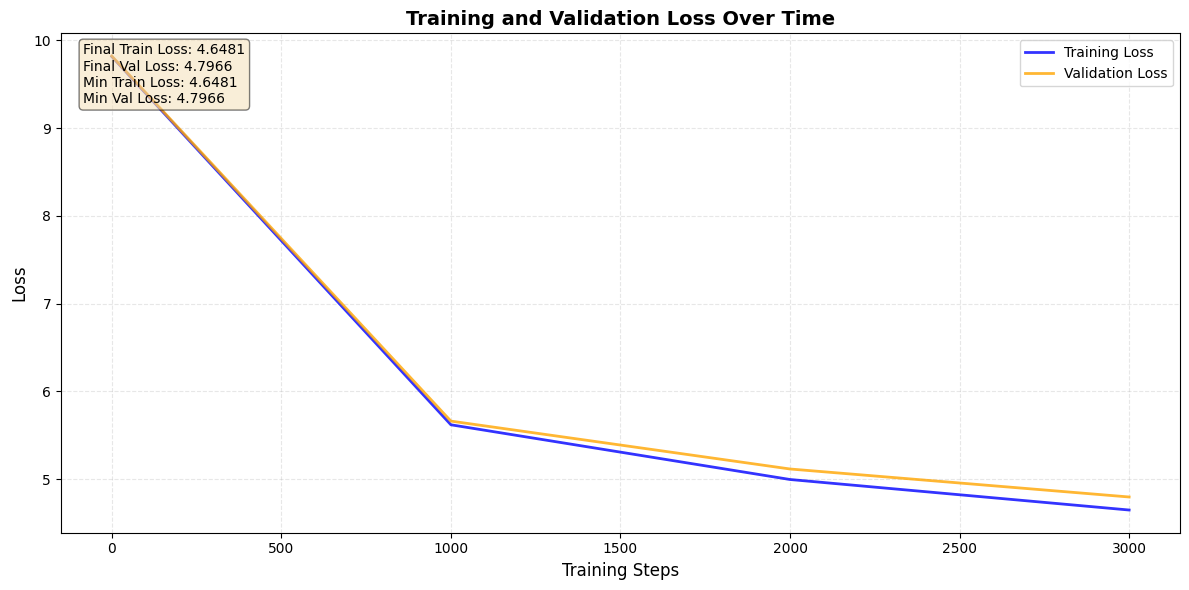

In [9]:
from scripts.visualize_losses import visualize_losses

visualize_losses(checkpoint_state_file)

As you can see we had a healthy training run. After running 2 epochs, we can see that the losses went down to about 4.6481 for training, and 4.7966 for validation. This is a lot better than the starting point of about 10 each. 

If we had more data and trained longer, we would certainly see the losses continue to go down.

## Factors

Here are some considerations:

- If the training loss begins to decrease, but the validation loss increases, or doesn't move, you may be overfitting.
- Run 2 separate epochs if you find that there is a lot of repetition in the generated text after some time. The learning rate you may have specified might be too aggressive. There is a difference between 3e-4 and 1e-4... Experiment with different learning rates.
- For me, I did a 10B token run, and the initial learning rate of 3e-4 was quite aggressive and I saw my mdoel degrade after batch 150,000/250,000. I had to stop and restart for a second epoch with a smaller learning rate of 1e-4. That fixed the model.


# Additional Utilities 

For longer training runs, you might want some of these handy utilities to use to save models at various steps and also be able to restart them. Modify them to your needs if necessary.

## Saving Periodically

There is a utility in `gpt2_common.py` called `save_training_state` that will allow you to save the model and optimizer periodically. In case of a crash, you can reload the latest checkpoint using `load_model_from_path` in `model_loger.py`. 

Look at the `train.py` file for an example in how to use this utility. :) 